# Evaluación de la pérdida de calidad del audio usando el codec OPUS

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 5 min read

---

## Resumen

Los estetoscopios digitales son herramientas que le permiten a los médicos realizar remotamente un seguimiento de sus pacientes sobre problemas relacionados con el corazón y los pulmones. En muchos de los casos, estos estetoscopios digitales utilizan codecs, como  el OPUS, que también son empleados en sistemas de teleconferencia como Zoom, MS Teams y Skype. A pesar de mostrar un excelente rendimiento para transmitir voz y música con bajas tasas de bits, los codecs eliminan frecuencias que son inaudibles para el oído humano y que podrían ser necesarias por los algoritmos de reconocimiento de patrones para detectar enfermedades. En este ipython notebook nos dimos a la tarea de realizar pruebas al códec OPUS para determinar si la pérdida de la calidad es realmente significativa. Los resultados mostraron que...

# Códec OPUS

El codificador de audio OPUS es el códec más empleado en los sistemas de teleconferencia por su capacidad de transmitir audio de alta calidad a bajas tasas de bit. Actualmente, a superado a otros códecs como el MP3, AAC, Vorbis, entre otros (ver figura 1). Está compuesto por dos algoritmos llamados [SILK](https://github.com/ploverlake/silk) (creado por Skype Limited para comprimir voz) y *Constrained Energy Lapped Transform* (CELT) (para comprimir música) [3, 4]. 

<img src='img/qualityOpus.png' width='50%'>
Figura 1. Tomada de https://opus-codec.org/static/comparison/quality.svg.

# Psicoacústica

La mayoría de códecs de sonido utilizan la teoría psicoacústica para "engañar" al oído humano eliminando las frecuencias inaudibles. Para ello, utilizan conceptos tales como las escalas Bark y ERB, bandas críticas, enmascaramiento frecuencial, enmascaramiento temporal y predicción lineal (LPC, por sus siglas en Inglés). A continuación hacemos un resumen de estos conceptos:

* **Cóclea:** órgano en forma cónica (ver figura 2) encargado de percibir las frecuencias y transmitirlas como impulsos eléctricos al cerebro. Se encuentra "arrollado" dentro del oído interno y recibe estímulos del oído externo e intermedio mediante la ventana oval (esta se conecta con los huesecillos conectados al tímpano).  

<img src='img/800px-Anatomy_of_the_Human_Ear.svg.png' width=40%>
Figura 2. Tomada de https://en.wikipedia.org/wiki/Auditory_system#/media/File:Anatomy_of_the_Human_Ear.svg.

* **Escalas Bark y ERB:** modelos matemáticos utilizados para representar la resolución frecuencial de la cóclea. Se basan en el hecho de que el oído humano realiza un mejor trabajo reconociendo tonos graves que tonos agudos (distribución logarítmica). La escala *Equivalent Rectangular Bandwidth* (ERB) es una versión mejorada de la escala Bark y su ecuación es $\text{ERB}(f)=21.4 \log_{10}{0.00437f+1}$, mostrada a continuación [9].

Populating the interactive namespace from numpy and matplotlib


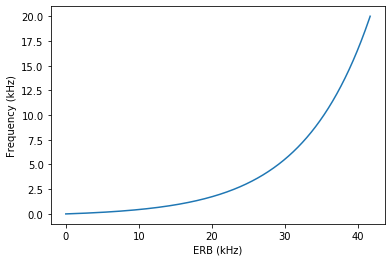

In [7]:
%pylab inline
import numpy as np

F = np.linspace(0,20000,1000)
erb = 21.4 * np.log10(0.00437*F+1)
pylab.plot(erb,F/1e3)
pylab.ylabel('Frequency (kHz)')
pylab.xlabel('ERB (kHz)')
pylab.show()

* **Bandas críticas:** segmentos de la cóclea, de diferente longitud y localización, en los cuales el oído humano no es capaz de diferenciar dos tonos lo suficientemente cercanos. Tres ejemplos de bandas críticas están en los rangos $[9, 12]$ kHz, $[12, 15]$ kHz y $[15, 20]$ kHz [10].

* **Enmascaramiento frecuencial:** fenómeno producido las bandas críticas (ver figura 3) donde la frecuencia de mayor energía enmascara a las de menor energía mediante su envolvente espectral. 
<img src='img/QA_2-0112.jpeg' width='50%'>
Figura 3. Tomada de https://output.com/blog/9-sound-design-tips-to-hack-your-listeners-ears.  
  
* **Enmascaramiento temporal:** fenómeno que ocurre cuando dos eventos ocurren lo suficientemente cercanos en el tiempo y el más fuerte enmascará al más débil si el segundo ocurre 10 ms antes (pre-enmascaramiento) o 30-60 ms después (post-enmascaramiento) que el primero [7] (ver figura 4).
<img src='img/3-Figure2-1.png' width=50%>
Figura 4. Tomada de https://d3i71xaburhd42.cloudfront.net/13674722d0e4fc8a6877773b25a62ee9850eb46a/3-Figure2-1.png.


# Casos de prueba

Basándonos en los conceptos de psicoacústica explicados arriba, podemos definir una serie de casos de prueba que el algoritmo OPUS tendría que superar para ser útil para un estetoscopio digital.

* **Caso 1.** Para dos tonos con frecuencia 9.5 kHz y 10kHz, solo el de 10kHz deberá escucharse si su energía es dominante (enmascariento frecuencial).
* **Caso 2.** El contenido de la magnitud espectral presente en un barrido de frecuencias debe mantenerse, sin que se agreguen o eliminen frecuencias.

Para probar el caso 2 se puede utilizar un barrido de frecuencias que siga la siguiente ecuación [6]
$$
F(t) = \Big(\frac{F_1-F_0}{T}\Big)t + F_0,
$$

El rango de frecuencias elegido fue $[20, 22.5K]$ Hz, que es el mismo rango admitido por los equipos electrónicos comerciales y también el rango de audición humana. El barrido puede ser construido usando un senoidal de la forma $x[t] = A \sin(2\pi Ft)$.

Para probar el caso 1, se puede agregar al barrido un tono adicional con energía más baja:

$$
x[t] = \sin(2\pi F_0 t) + 0.2 \sin(2\pi 1.1 F_0 t).
$$

Populating the interactive namespace from numpy and matplotlib


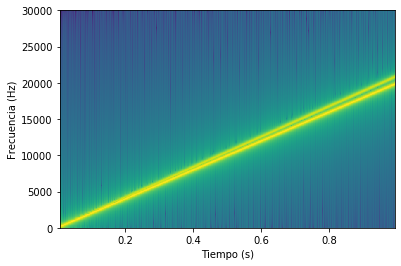

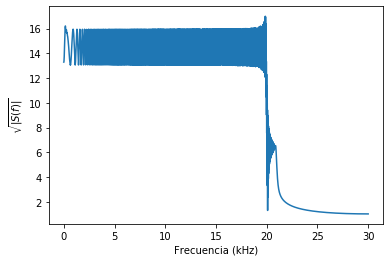

In [1]:
%pylab inline
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np

def plotSpecgram(x,Fs):
    # spectrogram
    fig, ax = pylab.subplots(nrows=1)
    ax.specgram(x, NFFT=1024, Fs=Fs, noverlap=900)
    pylab.xlabel('Tiempo (s)')
    pylab.ylabel('Frecuencia (Hz)')
    pylab.show()
    
def plotFFT(x,Fs):
    pylab.figure()
    N2=int(len(x)/2)
    F = np.linspace(0,Fs/2,N2)/1000
    X = np.sqrt(np.abs(np.fft.fft(x)[0:N2]))
    pylab.plot(F, X)
    X[0] = 0 # remove DC value
    pylab.xlabel('Frecuencia (kHz)')
    pylab.ylabel('$\sqrt{|S(f)|}$')
    pylab.show()

rango = [20.0, 20000.0] # el rango promedio de audicion humano en Hz
Fs = rango[1]*3 # 2 veces la freq. maxima para cumplir con el teorema del muestreo
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
x = np.sin(np.pi*F0/Fs*n) + 0.2*np.sin(np.pi*1.05*F0/Fs*n) # f=F0/Fs (discrete frequency)

plotSpecgram(x,Fs)
plotFFT(x,Fs)

wavfile.write('/tmp/barrido_20_20k.wav',int(Fs),x)
Audio(x, rate=Fs) 

La magnitud espectral de la señal de audio es una recta en el rango $[20, 20000]$ Hz, lo que significa que todas las frecuencias están presentes como era de esperar.

# Ejecución

Procedemos a codificar y decodificar el barrido de frecuencias usando OPUS para una tasa de bits de 8 Kbps (la misma empleada en una videollamada sencilla) [12]. 

/usr/bin/sh: 1: ffmpeg: not found
opusenc: symbol lookup error: opusenc: undefined symbol: opus_multistream_surround_encoder_create
/tmp/opusEnc.opus: No such file or directory


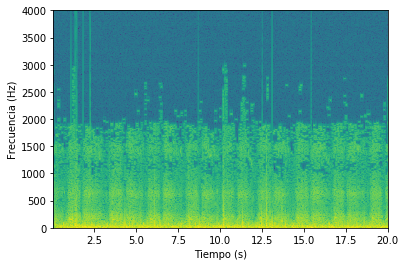

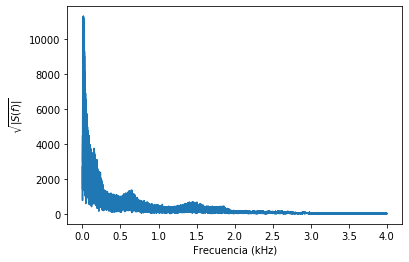

In [5]:
def readPlayVisualizeFile(inputFile):
    fs, x = wavfile.read(inputFile)
    y = np.array(x)/max(x)
    plotSpecgram(x,fs)
    return fs, x

# MP3
#!lame -b8 --quiet /tmp/barrido_20_20k.wav /tmp/opusEnc.mp3
#!lame --quiet --decode /tmp/opusEnc.mp3 /tmp/opusDec.wav
#!ls -sh /tmp/opusDec.wav

# OPUS
!ffmpeg -loglevel error -y -i /tmp/barrido_20_20k.wav -qscale 0 /tmp/wavRaw.wav # opus-tools
!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

Como se observa, las frecuencias más altas que 5K Hz fueron truncadas completamente. Probemos ahora con 128 kbps (fullband stereo) a ver si la calidad mejora.

96K /tmp/opusDec.wav


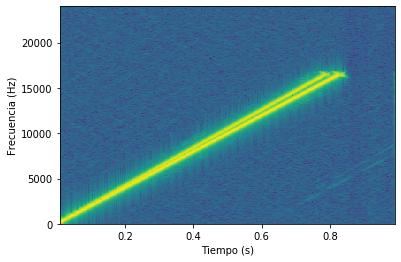

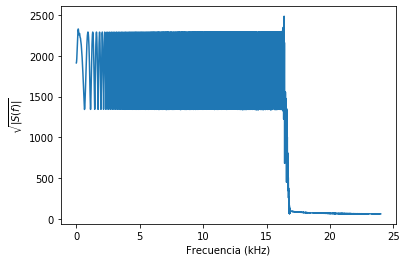

In [14]:
# MP3
!lame -b64 --quiet /tmp/barrido_20_20k.wav /tmp/opusEnc.mp3
!lame --quiet --decode /tmp/opusEnc.mp3 /tmp/opusDec.wav
!ls -sh /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

Observamos que el contenido frecuencial ha sufrido muchos cambios, entre ellos, se introdujeron frecuencias parásitas producto del aliasing o del [clipping](https://en.wikipedia.org/wiki/Clipping_(audio)), hay al menos 4 rectas principales en lugar de 2, también parece que se ha aplicado un filtro pasabajas con frecuencia de corte 20K Hz. Entonces sí que el codec Opus introduce distorsiones. Esto significa que si se aplica reconocimiento de patrones a una grabación procesada por Opus, el clasificador tendría información con mucho más ruido que con una grabación en formato WAV. 

Aún se pueden apreciar los dos tonos ubicados cerca de 10K Hz, por lo que la distorsión introducida para el Opus no ha sido mucha. Cabe preguntarse, ¿esto sucede porque se está usando CELT en lugar de SILK? ¿Podría forzarse usar SILK?

# 3 Analizando una grabación real

**Nota:** a partir de este momento se recomienda usar audifonos para apreciar mejor la calidad el audio.

Ahora realicemos una prueba procesando una grabación empleada en el reconocimiento de sonidos del cuerpo (una disciplina llamada auscultación). Para tomamos una grabación del sitio https://www.kaggle.com/vbookshelf/respiratory-sound-database. 

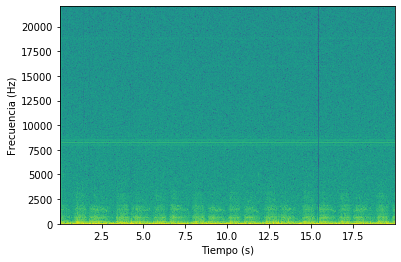

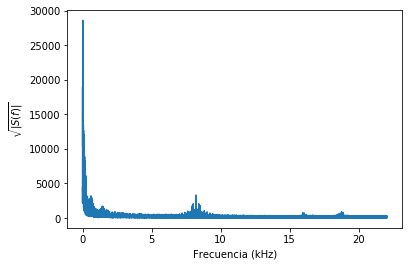

In [15]:
Fs, x = readPlayVisualizeFile('./wav/107_3p2_Tc_mc_AKGC417L_2.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

Observamos que hay energía alta en el rango $[0,1.5]$ y $[7.5,9.5]$ kHz.

Al parecer, la cantidad de bits usados tiene un efecto directamente proporcional sobre la frecuencia de corte. Además, observamos que la energía del rango $[0,1.5]$ se dispersó ahora por $[0,4.5]$ kHz y que el pic en $[7.5,9.5]$ kHz desapareció.

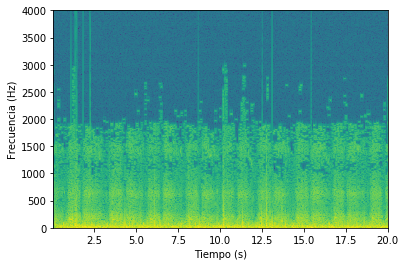

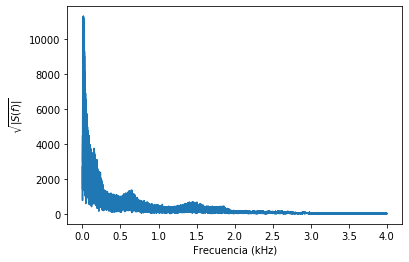

In [16]:
# MP3
!lame --quiet -b8 ./wav/107_3p2_Tc_mc_AKGC417L_2.wav /tmp/opusEnc.mp3
!lame --quiet --decode /tmp/opusEnc.mp3 /tmp/opusDec.wav

# OPUS
#!ffmpeg -loglevel error -y -i ./wav/107_3p2_Tc_mc_AKGC417L_2.wav -qscale 0 /tmp/wavRaw.wav # same quality
#!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
#!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

# 4 Conclusiones

En términos psicoacústicos, la distorsión del OPUS no parece estar en el enmascaramiento de frecuencias sino más bien en la presencia de contenido frecuencial que no estaba antes, producto de un fenómeno llamado clipping. Igualmente, esto podría afectar el rendimiento de un algoritmo de reconocimiento de patrones.


# Referencias
1. Colaboradores de Wikipedia. Códec de audio [en línea]. Wikipedia, La enciclopedia libre, 2020 [fecha de consulta: 4 de noviembre del 2020]. Disponible en <https://es.wikipedia.org/w/index.php?title=C%C3%B3dec_de_audio&oldid=129362034>. 
2. Hong  Kong  Polytechnic  University. Department of Electronic and Information Engineering. Perceptual Coding and MP3. Disponible en <http://www.eie.polyu.edu.hk/~enyhchan/DAP-lab-PModel-v3.pdf>.
3. López Monfort José Javier. Opus codec | 22/23 | UPV. Universitat Politècnica de València - UPV. Disponible en <https://youtu.be/2-yv1bCDL94>. 
4. Wikipedia contributors. (2020, October 11). SILK. In Wikipedia, The Free Encyclopedia. Retrieved 15:18, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=SILK&oldid=982904860
5. Wikipedia contributors. (2020, November 2). Linear predictive coding. In Wikipedia, The Free Encyclopedia. Retrieved 15:22, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=Linear_predictive_coding&oldid=986664067
6. EPFL. Room impulse responses. Ultima vez consultado el 27 Dec 2020 en: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb
7. López Monfort José Javier. Enmascaramiento Temporal | 4/23 | UPV. Disponible en <https://youtu.be/7NQvDoZMBM8> (consultado por última vez el 3 de Enero de 2021).
8. International Telecomunication Union (ITU-T). P.800.1, MOS.
9. Julius O. Smith III, Jonathan S. Abel. Equivalent Rectangular Bandwidth. Center for Computer Research in Music and Acoustics (CCRMA), Stanford University. Disponible en <https://ccrma.stanford.edu/~jos/bbt/Equivalent_Rectangular_Bandwidth.html> (consultado por última vez el 5 de Enero de 2021).
10. LCAV. Python MP3 encoder. Disponible en <https://github.com/LCAV/MP3Lab/blob/master/mp3python.ipynb> (consultado por última vez el 6 de Enero de 2021).
11. XIPH ORG. OpusFAQ. Disponible en <https://wiki.xiph.org/OpusFAQ#Why_not_keep_the_SILK_and_CELT_codecs_separate.3F> (consultado por última vez el 6 de Enero de 2021).
12. Tyler Abbott. How Much Data Does a Zoom Meeting Use?. Reviews ORG. Disponible en <https://www.reviews.org/internet-service/how-much-data-does-zoom-use/> (consultado por última vez el 16 de Enero de 2021).

--
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = { Pruebas por pares o pairwise testing},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.pairwisetesting.html},
  urldate = {}
}
```